# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project, I apply deep neural networks and convolutional neural networks to classify traffic signs. Specifically, I train a model to classify traffic signs from the German Traffic Sign Dataset.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [2]:
import pandas as pd

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = pd.read_csv("signnames.csv").shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

To get an idea what the images in the German Traffic Signs Dataset look like, let's visualize one sign of each class. 

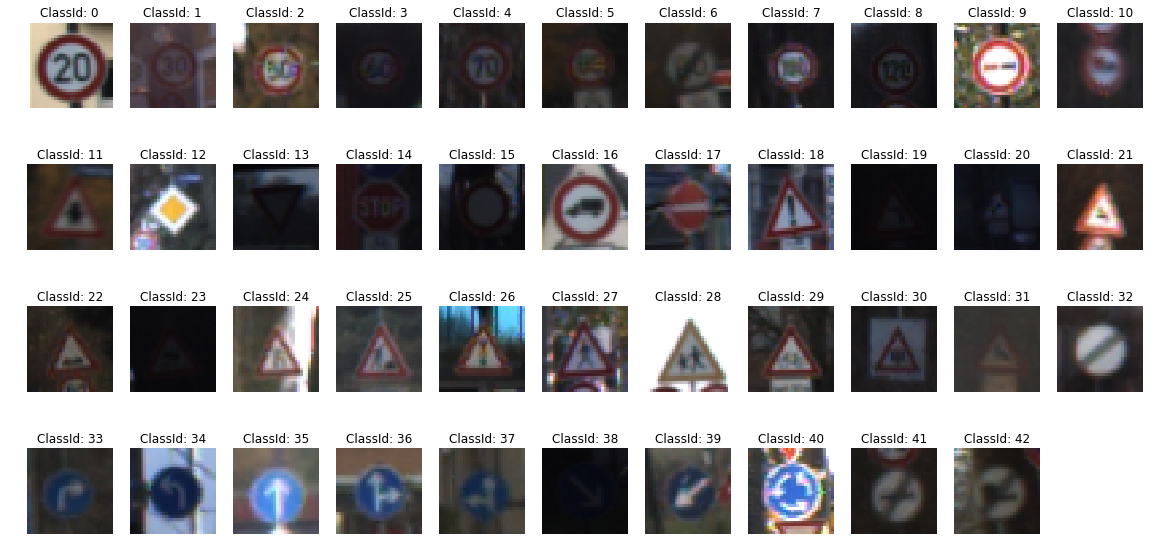

In [4]:
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# Plot sign of each class
plt.figure(figsize=(20, 10))
for i in range(n_classes):
    plt.subplot(4, 11, i+1)
    img = X_train[y_train == i][0]
    plt.axis('off')
    plt.title("ClassId: " + str(i))
    plt.imshow(img)
plt.show()

### Histogram of train, validation and test data

In [4]:
from collections import Counter
import plotly.offline as pltly
pltly.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [5]:
# Count signs per pabel
train_hist = Counter(y_train)
valid_hist = Counter(y_valid)
test_hist = Counter(y_test)

# Draw a bar chart
train_bar = go.Bar(x=list(train_hist.keys()), y=list(train_hist.values()), name="train")
valid_bar = go.Bar(x=list(valid_hist.keys()), y=list(valid_hist.values()), name="valid")
test_bar  = go.Bar(x=list(test_hist.keys()), y=list(test_hist.values()), name="test")
layout = go.Layout(height=500, width=1000, 
                   title='Distribution of train, validation and test data', 
                   xaxis=dict(title='Class Id'), 
                   yaxis=dict(title='# of images'))
pltly.iplot(go.Figure(data=[train_bar, valid_bar, test_bar], layout=layout))

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128) / 128` is a quick way to approximately normalize the data. 

Further, I decide to rescale the image data to a range of `[0,1]` by using `pixel / 255`, so the network can treat every feature equally.

In [6]:
# Preprocess the data. 
import numpy as np
import tensorflow as tf
import cv2

"""
    Converts an image to grayscale
"""
def rgb_to_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

"""
    Rotates an image randomly. 
"""
def rotate(image):
    rows, cols = image.shape[0], image.shape[1] 
    deg = 40.0*np.random.rand()-15
    M = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1.)
    return cv2.warpAffine(image, M, (cols, rows))

"""
    Changes contrast of image randomly. 
"""
def contrast(image):
    alpha = 1.5*np.random.rand()+0.5
    beta = 100.*np.random.rand()
    img = cv2.multiply(image, np.array([alpha]))
    return cv2.add(img, np.array([beta]))

"""
    Sharpens an image.
"""
def sharpen(image):
    gb = cv2.GaussianBlur(image, (5,5), 20.0)
    return cv2.addWeighted(image, 2, gb, -1, 0)

"""
    Creates an image for generation. 
"""
def create_image(image):
    return sharpen(contrast(rotate(image)))

"""
    Generates images.  
"""
def generate_images(X, y):
    mean = 1500 #np.mean(list(train_hist.values()))
    X_train_fake, y_train_fake = [], [] 
    for i, label in enumerate(y):
        if train_hist[label] < mean:
            c = int(mean / train_hist[label])
            for _ in range(c): 
                X_train_fake.append(create_image(X[i]))
                y_train_fake.append(label)
    return np.asarray(X_train_fake), np.asarray(y_train_fake)

In [7]:
# Generate rotated images
X_fake, y_fake = generate_images(X_train, y_train)

In [8]:
# Build training set
X_train = np.array(list(X_train) + list(X_fake))
y_train = np.array(list(y_train) + list(y_fake))

In [9]:
train_hist = Counter(y_train)

# Draw a bar chart
train_bar = go.Bar(x=list(train_hist.keys()), y=list(train_hist.values()), name="train")
layout = go.Layout(height=500, width=1000, 
                   title='Distribution of train data', 
                   xaxis=dict(title='Class Id'), 
                   yaxis=dict(title='# of images'))
pltly.iplot(go.Figure(data=[train_bar], layout=layout))

In [10]:
X_train.shape, y_train.shape

((81417, 32, 32, 3), (81417,))

In [11]:
# Convert to grayscale
X_train_gray = rgb_to_grayscale(X_train) 
X_valid_gray = rgb_to_grayscale(X_valid) 
X_test_gray = rgb_to_grayscale(X_test)

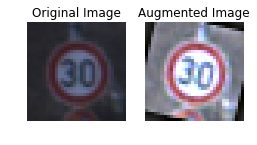

In [12]:
# Plot a grayscale image
plt.subplot(1, 3, 1)
plt.imshow(X_train[4000])
plt.title("Original Image")
plt.axis('off')  
plt.subplot(1, 3, 2)
plt.imshow(create_image(X_train[4000]))
plt.title("Augmented Image")
plt.axis('off')
plt.show() 

In [13]:
# Normalize 
X_train = np.array(X_train_gray, np.float32) / 255.
X_valid = np.array(X_valid_gray, np.float32) / 255.
X_test = np.array(X_test_gray, np.float32) / 255.

In [14]:
X_train = np.expand_dims(X_train, axis=3)
X_valid = np.expand_dims(X_valid, axis=3)
X_test = np.expand_dims(X_test, axis=3)

### Model Architecture

In [42]:
### Define your architecture here.
from tensorflow.contrib.layers import flatten

# Convolutional Layer
def conv2d_block(x, kernel_size, filters, padding='VALID'):
    conv_W = tf.Variable(tf.truncated_normal(shape=(kernel_size[0], kernel_size[1], x.shape[3].value, filters), mean = 0, stddev = 0.1))
    conv_b = tf.Variable(tf.zeros(filters))
    conv = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding=padding) + conv_b
    return tf.nn.relu(conv)

# Max Pooling Layer
def max_pool(x, stride):
    return tf.nn.max_pool(x, ksize=[1, stride, stride, 1], strides=[1, stride, stride, 1], padding='VALID')

# Fully-Connection Layer
def fc_block(x, n_out, keep_prob=1.):
    fc_W = tf.Variable(tf.truncated_normal(shape=(x.shape[1].value, n_out), mean = 0, stddev = 0.1))
    fc_b = tf.Variable(tf.zeros(n_out))
    fc = tf.matmul(x, fc_W) + fc_b
    fc = tf.nn.relu(fc)
    return tf.nn.dropout(fc, keep_prob)

# Output Layer
def output_block(x, n_out):
    fc_W = tf.Variable(tf.truncated_normal(shape=(x.shape[1].value, n_out), mean = 0, stddev = 0.1))
    fc_b = tf.Variable(tf.zeros(n_out))
    return tf.matmul(x, fc_W) + fc_b

# Model Architecture
def create_model(x, keep_prob):    
    conv1 = conv2d_block(x, kernel_size=[5, 5], filters=32, padding='VALID')
    conv1 = conv2d_block(conv1, kernel_size=[5, 5], filters=32, padding='VALID')
    conv1 = max_pool(conv1, stride=2)
    
    conv2 = conv2d_block(conv1, kernel_size=[5, 5], filters=64, padding='VALID')
    conv2 = conv2d_block(conv2, kernel_size=[5, 5], filters=64, padding='VALID')
    conv2 = max_pool(conv2, stride=2)
    
    fc0 = flatten(conv2)
    fc1 = fc_block(fc0, 128, keep_prob)
    fc2 = fc_block(fc1, 64, keep_prob+0.25)
    logits = output_block(fc2, n_classes) 
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
import tensorflow as tf
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Dropout keep probability
keep_prob = tf.placeholder(tf.float32)

# Number of epochs
epochs = 10

# Batch size
batch_size = 32

# Learning rate
lr = 0.001

In [17]:
# Model 
logits = create_model(x, keep_prob)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits))
training_operation = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [18]:
def evaluate(X_data, y_data, batch_size=32):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.}) 
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples), (total_loss / num_examples)

In [19]:
import time
# Run training session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for epoch in range(epochs):
        start = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .5})
            acc, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})    
        val_acc, val_loss = evaluate(X_valid, y_valid, batch_size)
        end = time.time()
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("{}s - loss = {:.3f} - acc = {:.3f} - val_loss = {:.3f} - val_acc = {:.3f}".format(int(end-start), loss, acc, val_loss, val_acc))
        print()
        
    saver.save(sess, './traffic_sign')
    print("Model saved")

Training...

Epoch 1/10
358s - loss = 0.129 - acc = 1.000 - val_loss = 0.135 - val_acc = 0.962

Epoch 2/10
420s - loss = 0.224 - acc = 0.889 - val_loss = 0.124 - val_acc = 0.971

Epoch 3/10
423s - loss = 0.005 - acc = 1.000 - val_loss = 0.076 - val_acc = 0.980

Epoch 4/10
432s - loss = 0.000 - acc = 1.000 - val_loss = 0.090 - val_acc = 0.979

Epoch 5/10
394s - loss = 0.013 - acc = 1.000 - val_loss = 0.067 - val_acc = 0.984

Epoch 6/10
416s - loss = 0.022 - acc = 1.000 - val_loss = 0.055 - val_acc = 0.988

Epoch 7/10
400s - loss = 0.000 - acc = 1.000 - val_loss = 0.086 - val_acc = 0.982

Epoch 8/10
415s - loss = 0.008 - acc = 1.000 - val_loss = 0.064 - val_acc = 0.983

Epoch 9/10
396s - loss = 0.000 - acc = 1.000 - val_loss = 0.106 - val_acc = 0.976

Epoch 10/10
412s - loss = 0.000 - acc = 1.000 - val_loss = 0.072 - val_acc = 0.985

Model saved


In [20]:
# Test the trained model
with tf.Session() as sess:
    saver.restore(sess, './traffic_sign')
    test_accuracy, test_loss = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.965


---

## Step 3: Test a Model on New Images

Download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [21]:
# Get list of sign names 
signnames = pd.read_csv("signnames.csv")["SignName"].tolist()

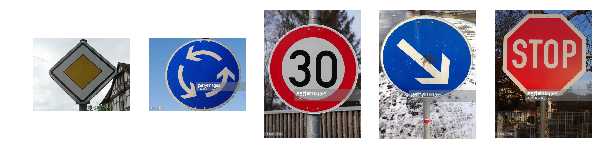

In [22]:
# Load and plot the images.
import os, cv2 
# Path of test images
img_path = "eval/"
# Get all images
images = []
plt.figure(figsize=(10, 10))
for i, filename in enumerate(os.listdir(img_path)):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(os.path.join(img_path, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    plt.axis('off')
    plt.imshow(img)
plt.show() 

### Predict the Sign Type for Each Image

In [23]:
### Preprocess the images
# Resize to 32x32
test_images = [cv2.resize(img, (32, 32)) for img in images]
# Convert to grayscale 
test_images = rgb_to_grayscale(test_images) 
# Normalize 
test_images = np.array(test_images, np.float32) / 255.

In [35]:
### Predict
with tf.Session() as sess:
    saver.restore(sess, './traffic_sign')
    preds = sess.run(tf.argmax(logits, 1), feed_dict={x: np.expand_dims(test_images, axis=3), keep_prob: 1.})

### Analyze Performance

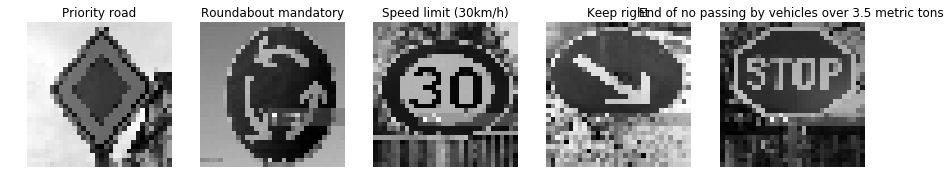

In [38]:
### Calculate the accuracy for these 5 new images. 
plt.figure(figsize=(15, 15))
for i, pred in enumerate(preds):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title(signnames[pred])
    plt.imshow(test_images[i], cmap='gray')
plt.show() 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

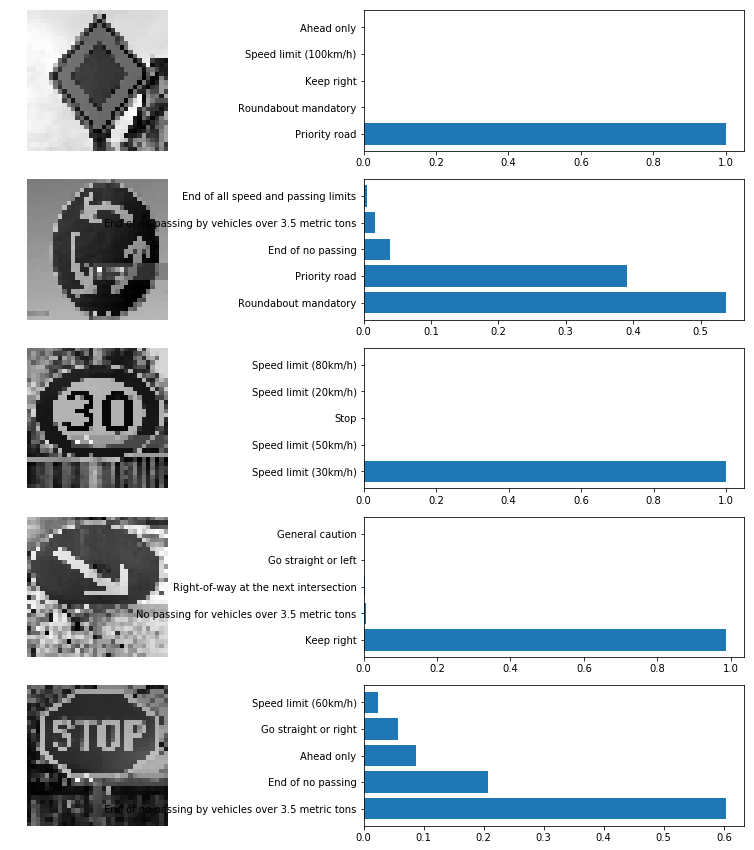

In [34]:
# Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, './traffic_sign')
    probs = sess.run(tf.nn.softmax(logits), feed_dict={x: np.expand_dims(test_images, axis=3), keep_prob: 1.})
    top5 = sess.run(tf.nn.top_k(probs, k=5))

plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(test_images[i], cmap='gray') 
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), top5.values[i, :])
    labs=[signnames[j] for j in top5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()